In [1]:
import os
import csv
import numpy as np
import nibabel as nib
from scipy.ndimage import label
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# CONFIGURACIÓN

NNUNET_DIR = r"C:\Users\marta\Desktop\microbleeds\nnUNet_raw_data\TaskVALDO"
LABELS_DIR = os.path.join(NNUNET_DIR, "labelsTr")

# Nombre actualizado para el análisis
OUTPUT_CSV = "/media/guest/PORT-DISK/Practicas/MicroBleeds/VALDO_analisis_por_cohortes.csv"

In [3]:
# FUNCIONES AUXILIARES

def get_cohort(subject_id):
    """
    Determina la cohorte basándose en el ID del paciente.
    sub-1xx -> SABRE (UK)
    sub-2xx -> RSS (Rotterdam)
    sub-3xx -> ALFA (Barcelona)
    """
    try:
        parts = subject_id.split('-')
        if len(parts) > 1:
            num_str = parts[1]
            if num_str.startswith('1'):
                return "SABRE"
            elif num_str.startswith('2'):
                return "RSS"
            elif num_str.startswith('3'):
                return "ALFA"
    except Exception:
        pass
    return "Unknown"

def analyze_mask(label_path):
    """
    Analiza la máscara y devuelve el número de lesiones y sus volúmenes en cm³.
    """
    nii = nib.load(label_path)
    mask = nii.get_fdata().astype(np.uint8)

    # Tamaño de voxel en mm (dx, dy, dz)
    voxel_sizes = nii.header.get_zooms()[:3]
    # Volumen de un solo vóxel en mm³
    one_voxel_vol_mm3 = voxel_sizes[0] * voxel_sizes[1] * voxel_sizes[2]

    # Connected components (etiquetar cada lesión individualmente)
    labeled, num = label(mask)

    lesion_volumes_vox = []
    lesion_volumes_cm3 = []

    for lesion_idx in range(1, num + 1):
        # Conteo de vóxeles para esta lesión
        voxel_count = int(np.sum(labeled == lesion_idx))
        lesion_volumes_vox.append(voxel_count)

        # Cálculo de volumen:
        # 1. Volumen en mm³ = vóxeles * volumen_voxel
        vol_mm3 = voxel_count * one_voxel_vol_mm3
        
        # 2. Conversión a cm³ (1 cm³ = 1000 mm³)
        vol_cm3 = round(vol_mm3 / 1000.0, 6) # Usamos 6 decimales por ser lesiones muy pequeñas
        
        lesion_volumes_cm3.append(vol_cm3)

    return num, lesion_volumes_vox, lesion_volumes_cm3

In [4]:
# PROCESAMIENTO DE DATOS Y GENERACIÓN CSV

rows = []
label_files = sorted([f for f in os.listdir(LABELS_DIR) if f.endswith(".nii.gz")])

print(f"Procesando {len(label_files)} sujetos...")

for f in label_files:
    subject = f.replace(".nii.gz", "")
    path = os.path.join(LABELS_DIR, f)
    
    # Identificar cohorte
    cohort = get_cohort(subject)

    # Analizar máscara
    num_lesions, lesion_volumes_vox, lesion_volumes_cm3 = analyze_mask(path)

    if num_lesions == 0:
        # Paciente sin lesiones → fila única con ceros
        rows.append([subject, cohort, 0, 0, 0.0])
    else:
        # Una fila por cada lesión encontrada
        for vvox, vcm3 in zip(lesion_volumes_vox, lesion_volumes_cm3):
            rows.append([subject, cohort, num_lesions, vvox, vcm3])

# Guardar CSV
with open(OUTPUT_CSV, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    # Cabecera clara
    writer.writerow(["subject", "cohort", "num_lesions_patient", "lesion_vol_voxels", "volume_cm3"])
    writer.writerows(rows)

print("Análisis completado. CSV guardado en:", OUTPUT_CSV)

Procesando 72 sujetos...
Análisis completado. CSV guardado en: C:\Users\marta\Desktop\microbleeds\VALDO_analisis_por_cohortes.csv



--- Vista previa de los datos ---
   subject cohort  num_lesions_patient  lesion_vol_voxels  volume_cm3
0  sub-101  SABRE                   14                 16    0.012915
1  sub-101  SABRE                   14                  9    0.007265
2  sub-101  SABRE                   14                 22    0.017758
3  sub-101  SABRE                   14                 14    0.011301
4  sub-101  SABRE                   14                 81    0.065382


<Figure size 1000x600 with 0 Axes>

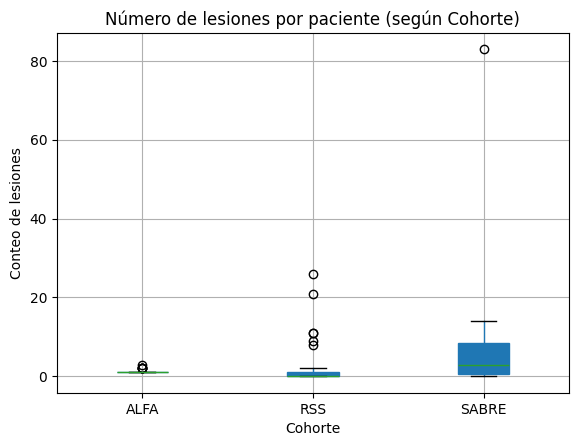

<Figure size 1000x600 with 0 Axes>

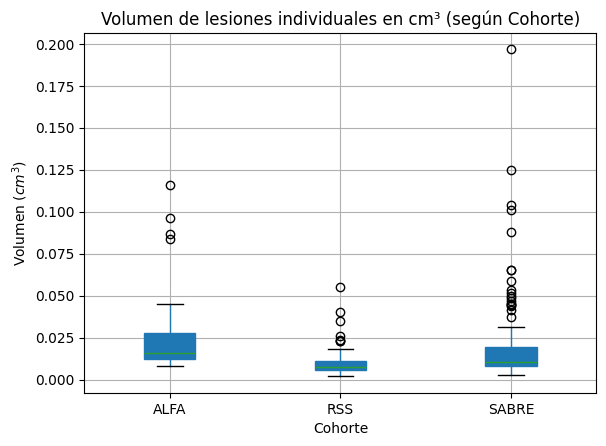


=== RESUMEN ESTADÍSTICO ===

>> Conteo de lesiones por paciente (Media +/- Std):
             mean        std  max  count
cohort                                  
ALFA     1.259259   0.525693    3     27
RSS      2.823529   6.142108   26     34
SABRE   11.181818  24.268573   83     11

>> Volumen de lesiones en cm³ (Media +/- Std):
            mean    median       std       max
cohort                                        
ALFA    0.027499  0.016000  0.027149  0.115987
RSS     0.009799  0.007629  0.007836  0.054932
SABRE   0.020639  0.010493  0.026332  0.196954


In [4]:
# VISUALIZACIÓN POR COHORTES

# Cargar el CSV recién creado
df = pd.read_csv(OUTPUT_CSV)

print("\n--- Vista previa de los datos ---")
print(df.head())

# --- GRÁFICO 1: Número de lesiones por paciente (Comparativa por Cohorte) ---
# Agrupamos por paciente (tomamos el primer valor ya que 'num_lesions_patient' se repite por fila)
df_patients = df.groupby(["subject", "cohort"])["num_lesions_patient"].first().reset_index()

plt.figure(figsize=(10, 6))
df_patients.boxplot(column="num_lesions_patient", by="cohort", grid=True, patch_artist=True)
plt.title("Número de lesiones por paciente (según Cohorte)")
plt.suptitle("") # Limpiar título automático
plt.ylabel("Conteo de lesiones")
plt.xlabel("Cohorte")
plt.show()

# --- GRÁFICO 2: Volumen de lesiones individuales en cm³ (Comparativa por Cohorte) ---
# Filtramos para no graficar el volumen "0" de los pacientes sanos
df_lesions = df[df["volume_cm3"] > 0]

plt.figure(figsize=(10, 6))
df_lesions.boxplot(column="volume_cm3", by="cohort", grid=True, patch_artist=True)
plt.title("Volumen de lesiones individuales en cm³ (según Cohorte)")
plt.suptitle("")
plt.ylabel("Volumen ($cm^3$)")
plt.xlabel("Cohorte")
plt.show()

# --- ESTADÍSTICAS EN TEXTO ---
print("\n=== RESUMEN ESTADÍSTICO ===")
print("\n>> Conteo de lesiones por paciente (Media +/- Std):")
print(df_patients.groupby("cohort")["num_lesions_patient"].agg(['mean', 'std', 'max', 'count']))

print("\n>> Volumen de lesiones en cm³ (Media +/- Std):")
print(df_lesions.groupby("cohort")["volume_cm3"].agg(['mean', 'median', 'std', 'max']))

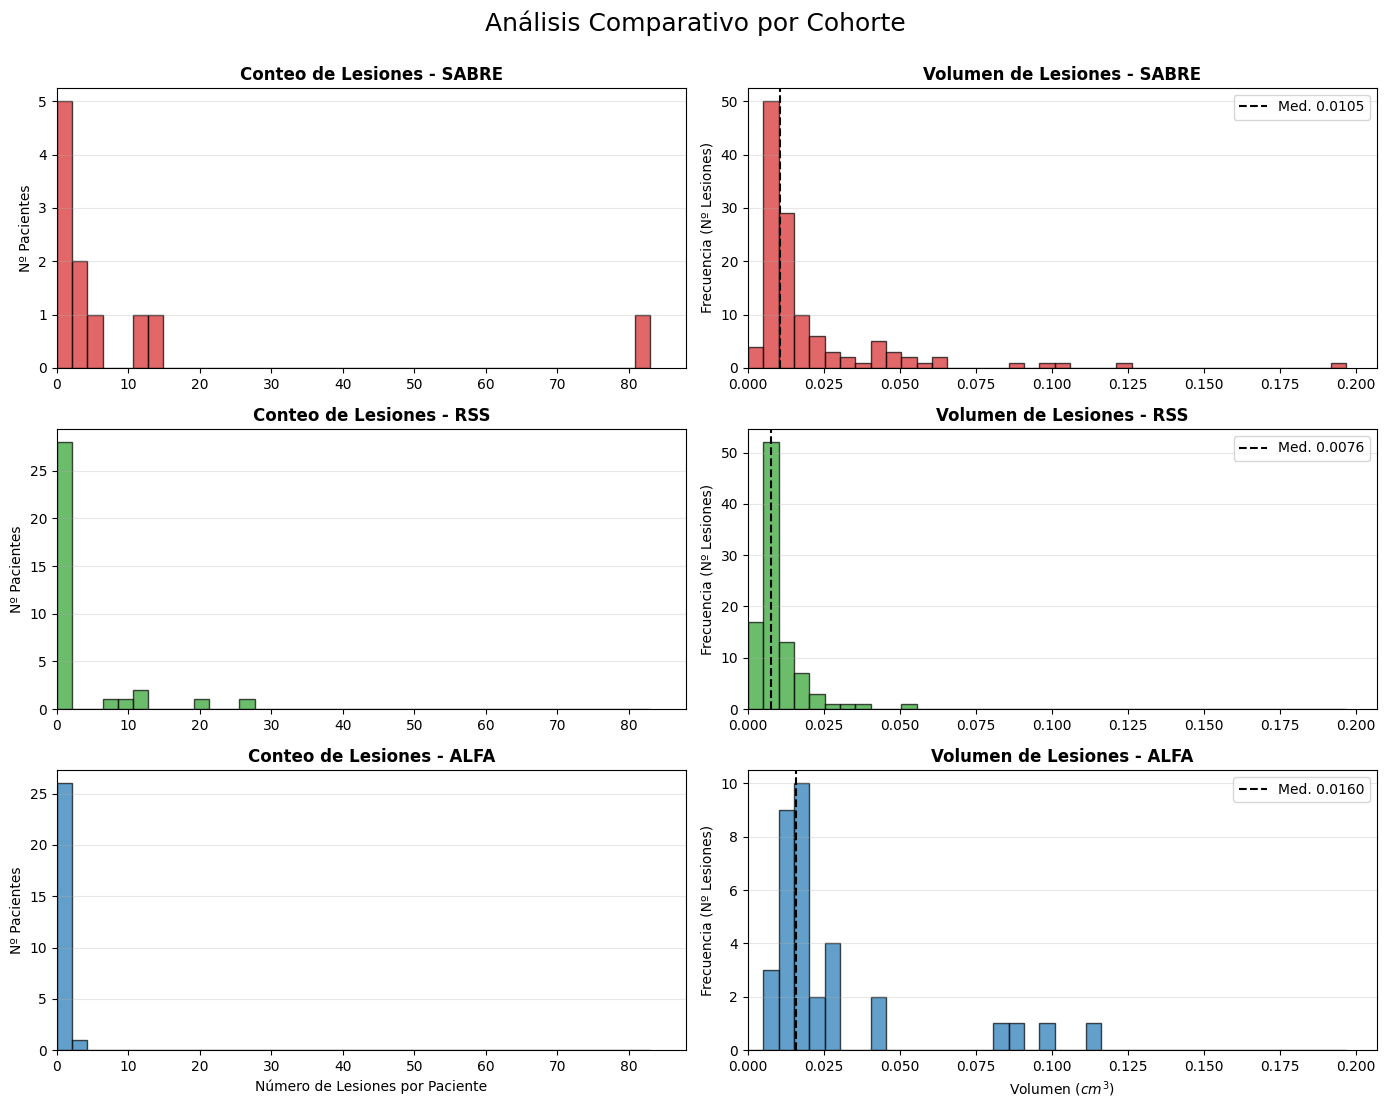

In [8]:
# CARGA DE DATOS

OUTPUT_CSV = "/media/guest/PORT-DISK/Practicas/MicroBleeds/VALDO_analisis_por_cohortes.csv"
df = pd.read_csv(OUTPUT_CSV)

# Definir el orden específico de las filas
cohorts_order = ["SABRE", "RSS", "ALFA"]
colors = {'SABRE': '#d62728', 'RSS': '#2ca02c', 'ALFA': '#1f77b4'} # Rojo, Verde, Azul

# Preparar datos agregados
df_patients = df.groupby(["subject", "cohort"], observed=False)["num_lesions_patient"].first().reset_index()
df_lesions = df[df["volume_cm3"] > 0]

# CÁLCULO DE LÍMITES GLOBALES (Para unificar ejes)

# Buscamos el valor máximo de TODO el dataset para que todos los gráficos usen la misma escala
max_num_lesiones = df_patients["num_lesions_patient"].max()
max_volumen = df_lesions["volume_cm3"].max()

# Definimos los límites del Eje X con un pequeño margen
xlim_lesiones = (0, max_num_lesiones + 5)
xlim_volumen = (0, max_volumen + 0.01)

# GENERACIÓN DE GRÁFICOS (GRID 3x2)

# Creamos una figura con 3 filas y 2 columnas
fig, axes = plt.subplots(3, 2, figsize=(14, 12)) # Alto ajustado para 3 filas
fig.suptitle('Análisis Comparativo por Cohorte', fontsize=18, y=0.95)

for i, cohort in enumerate(cohorts_order):
    # Seleccionar ejes de la fila actual
    ax_izq = axes[i, 0] # Histograma de Número (Izquierda)
    ax_der = axes[i, 1] # Histograma de Volumen (Derecha)
    
    # --- A. GRÁFICO IZQUIERDO: NÚMERO DE LESIONES ---
    data_pat = df_patients[df_patients["cohort"] == cohort]
    
    if len(data_pat) > 0:
        # Usamos bins consistentes para todo el rango
        bins_num = np.linspace(0, max_num_lesiones, 40) 
        ax_izq.hist(data_pat["num_lesions_patient"], bins=bins_num, color=colors[cohort], alpha=0.7, edgecolor='black')
    
    # Configuración Ejes Izquierda
    ax_izq.set_title(f"Conteo de Lesiones - {cohort}", fontsize=12, fontweight='bold')
    ax_izq.set_ylabel("Nº Pacientes")
    ax_izq.set_xlim(xlim_lesiones) # <--- AQUÍ UNIFICAMOS LA ESCALA
    ax_izq.grid(axis='y', alpha=0.3)
    
    # Solo ponemos etiqueta X en la última fila para no ensuciar
    if i == 2: ax_izq.set_xlabel("Número de Lesiones por Paciente")

    # --- B. GRÁFICO DERECHO: VOLUMEN ---
    data_vol = df_lesions[df_lesions["cohort"] == cohort]
    
    if len(data_vol) > 0:
        # Usamos bins consistentes
        bins_vol = np.linspace(0, max_volumen, 40)
        ax_der.hist(data_vol["volume_cm3"], bins=bins_vol, color=colors[cohort], alpha=0.7, edgecolor='black')
        
        # Mediana
        mediana = data_vol["volume_cm3"].median()
        ax_der.axvline(mediana, color='black', linestyle='--', linewidth=1.5, label=f'Med. {mediana:.4f}')
        ax_der.legend(loc='upper right')

    # Configuración Ejes Derecha
    ax_der.set_title(f"Volumen de Lesiones - {cohort}", fontsize=12, fontweight='bold')
    ax_der.set_ylabel("Frecuencia (Nº Lesiones)")
    ax_der.set_xlim(xlim_volumen) # <--- AQUÍ UNIFICAMOS LA ESCALA
    ax_der.grid(axis='y', alpha=0.3)
    
    if i == 2: ax_der.set_xlabel("Volumen ($cm^3$)")

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajuste para que no se corte el título grande
plt.show()